# Hyperparameter optimization

In machine learning hyperparameter optimization is the process of finding a set of optimal hyperparameters for a machine learning model. Hyperparameters need to be distinguished from model's parameters. Model's parameters are set by the learning algorithm during the training process, while hyperparameters are set by engineers or developers before initiating the training. In practice, we usually look for a set of hyperparameters that minimize the loss function:

$$
x_{*} = argmin \; f(x),
$$

where $f(x)$ is the function which we are trying to minimize (usually the loss function) and $x_{*}$ is the optimal setup of the hyperparameter vector that we are looking for.

It is important to note here that $f(x)$ has some characteristics that make this work tedious:

* $f(x)$ is indifferentiable in regards to $x$, which means that gradient based techniques are off the table.
* It takes a long time to compute the value of $f(x)$ for a given value of $x$, meaning that is extremely expensive to calculate the value of $f(x)$ for a lot of different inputs.
* From our perspective $f(x)$ is more or less a black box that we can probe only a couple of times.

A practical example of this process would be training a deep neural network for a regression task where we use mean squared error (MSE) as our loss function. Let us assume that the training process takes around 10 hours, during training the learning algorithm will find a set of weights and biases that minimizes the loss function. However, there are a bunch of hyperparameters that also influence the quality of the model (the loss function) and those need to be set by the engineer, to name a few: learning rate, batch size, optimizer, network architecture ... Each of these hyperparameters has many values and testing all combinations is infeasible as testing a single combination takes 10 hours. We can alleviate this by testing only a subset of hyperparameters, the scientific field of hyperparameter optimization tries to find methods for getting an optimal set of hyperparameters as quickly as possible.

So, one might look at the problem of hyperparameter optimization as a problem of finding a set of hyperparameters that minimizes the loss function. For the purpose of this lecture we will create a toy loss function which means that we know exactly what it looks like in regards to our hyperparameter. Next, we will try finding the optimal value for the hyperparameter by using different hyperparameter optimization techniques.

The code block below defines the shape of our loss function, we are interested in finding the value of our hyperparmeter $x$ that minimizes this function on the [0, 3] interval.

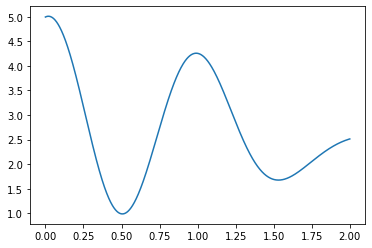

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def loss_function(x, print_value = False):
    """
    A random toy loss function.

    Parameters:
        x (float): the input value
        print_value (bool): whether to print the value of the loss function
    """
    value = x + (1 - 1 / 1 * np.sin(12 * x + 3) / (10 + x) + (3 * np.cos(3 * x)) ** 2) / (x ** 4 + 2)
    if print_value:
        # if value is a numpy array
        if hasattr(value, "__iter__"):
            for i in range(len(x)):
                print(f"loss_function({x[i]}) = {value[i]}")
        else:
            print(f"loss_function({x}) = {value}")
    return value

# plot the loss function from 0 to 2
start = 0
end = 2
x_loss = np.linspace(start, end, 1000)
y_loss = [loss_function(i) for i in x_loss]
plt.plot(x_loss, y_loss)

As you can see the optimal setting for our hyperparameter $x$ is somewhere around 1.6. For the sake of this lecture, we will assume that we can only afford to evalute $f(x)$ (train our model) 10 times. The first method we will talk about is called manual search.

## Manual search

We will only briefly mention this method as it is not the most transparent and reproducible. The logic here is that the engineer tries a couple of values and somehow imagines the shape of the loss function in his head. After that the engineer uses his intuition and expertise to move around and explore that space in an educated manner. Obviously, this is suboptimal and not completely reproducible by other engineers. But this approach is often used in the ideation/exploration phase to get some kind of a feeling about how various hyperparameters influence our model's training. But when looking for the optimal set of hyperparameters this approach is usually discarded and other, more systematic techniques take its place. Below is a (silly) example about how one might use this technique to find the optimal $x$ in our use case.

loss_function(0) = 4.992943999597006
loss_function(2) = 2.5120913789034724
loss_function(1) = 4.2538830711829085
loss_function(1.5) = 1.6879166240422552
loss_function(1.75) = 2.0520636823431264
loss_function(1.625) = 1.7674063916252687
loss_function(1.55) = 1.678921323871439
loss_function(1.525) = 1.6753007114861445
loss_function(1.53) = 1.6747847257642352
loss_function(1.56) = 1.6844910130088455

min x_manual = 1.53


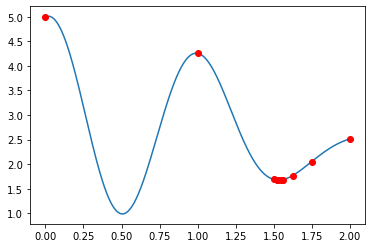

In [51]:
# let's start at the beginning
x_manual = []
y_manual = []

# let's start at 0
x = 0
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

# let's try the other end
x = 2
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

# let's try in between
x = 1
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

# now it is larger, let's look at 1.5
x = 1.5
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

# looking good, keep going
x = 1.75
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

x = 1.625
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

x = 1.55
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

x = 1.525
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

x = 1.53
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

x = 1.56
x_manual.append(x)
y_manual.append(loss_function(x, print_value=True))

# find minimum y_manual and it's x_manual
min_y_manual = min(y_manual)
min_x_manual = x_manual[y_manual.index(min_y_manual)]
print(f"\nmin x_manual = {min_x_manual}")

# plot loss_function from above along with x_manual and y_manual points
plt.plot(x_loss, y_loss)
plt.plot(x_manual, y_manual, 'ro')

There, by moving around with some kind of a manual "pedestrian gradient descent" we reached the value $x = 0.57$, as we can see from the figure above, this is not really the global optimum and there are a bunch of better values. This is a silly illustration where we have a single dimension (single hyperparameter), you can imagine that this becomes even worse in higher dimensions where hyperparameters might also interact.

## Grid search

Also called parameter sweep, is probably the most traditional method for peforming hyperparmaeter optimization. For each of the hyperparameters we define a discrete subset of values we would like to explore and then test all combinations. As expected, the sparsity of the grid increases as we have more and more parameters, since we can usually test only a small amount of all possible combinations, we have to reduce the resolution of our search protocol in order to retain a feasible amount of combinations.

In our case, when we have only a single hyperparameter we will be able to test values of $x$ that are approximately 0.22 units away from each other. If we had another parameters, say $x_2$, we would have to decrease the $x$ resolution in order to remain within the 10 managable tests. With two hyperparameters we could only test 5 values of $x$ and 2 values of $x_2$ for example. This outlines the main issue with grid search, it does not really scale that well. Because of this, we often have to set constant values to some hyperparameters and only explore how a small subset of everything we can tune influences the final result.

Below is an example of grid search on our toy example:


loss_function(0.0) = 4.992943999597006
loss_function(0.2222222222222222) = 3.52576010719189
loss_function(0.4444444444444444) = 1.1374625763645532
loss_function(0.6666666666666666) = 1.8736361937801944
loss_function(0.8888888888888888) = 3.9511427764208147
loss_function(1.1111111111111112) = 3.8708740652393256
loss_function(1.3333333333333333) = 2.2696827506610675
loss_function(1.5555555555555554) = 1.6817408890949044
loss_function(1.7777777777777777) = 2.1203773081514945
loss_function(2.0) = 2.5120913789034724

min x_grid = 0.4444444444444444


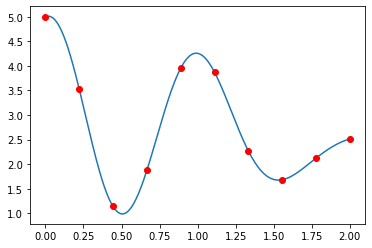

In [52]:
# create the grid
x_grid = np.linspace(start, end, 10)

# evaluate the loss function at each point in the grid
y_grid = loss_function(x_grid, print_value=True)

# find minimum y_grid and it's x_grid
min_x_grid = x_grid[np.argmin(y_grid)]
print(f"\nmin x_grid = {min_x_grid}")

# plot loss_function from above along with x_grid and y_grid points
plt.plot(x_loss, y_loss)
plt.plot(x_grid, y_grid, 'ro')

As you can see, grid search found a quite decent value at $x = 0.4444$. However, there are still better values to be found. The next approach that we will take a look at is called random search.

## Random search

Random Search replaces the exhaustive enumeration of all defined combinations by selecting them randomly, meaning that we can define a larger amount of combinations and then test only a subset of them through random selection. A benefit over grid search is that random search can explore many more values than grid search could for continuous hyperparameters. It can outperform grid search, especially when only a small number of hyperparameters affects the final performance of the machine learning algorithm. In this case, the optimization problem is said to have a low intrinsic dimensionality. Random search also allows the inclusion of prior knowledge by specifying the distribution from which to sample.

loss_function(1.295053079644367) = 2.5215473070601364
loss_function(0.7050684765769566) = 2.261537043105542
loss_function(0.4797023170508372) = 1.013589983985094
loss_function(1.320232943123685) = 2.3518626107781264
loss_function(0.17125388946319586) = 4.128968300024713
loss_function(1.3834799437760017) = 2.0006313856353684
loss_function(0.7061697015886372) = 2.2730501059267505
loss_function(1.074129763415962) = 4.063392588802471
loss_function(1.446354313809131) = 1.777266015697536
loss_function(0.8951427950370381) = 3.9870121238236393

min x_random = 0.4797023170508372


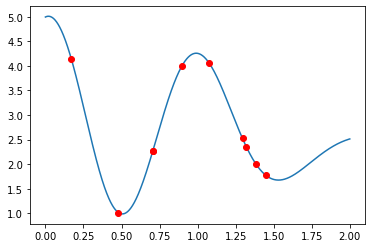

In [53]:
# get 10 random values from 0 to 2
x_random = np.random.uniform(start, end, 10)

# evaluate the loss function at each point in the grid
y_random = loss_function(x_random, print_value=True)

# find minimum y_grid and it's x_grid
min_x_random = x_random[np.argmin(y_random)]
print(f"\nmin x_random = {min_x_random}")

# plot loss_function from above along with x_random and y_random points
plt.plot(x_loss, y_loss)
plt.plot(x_random, y_random, 'ro')

Well, random is random so the end results is left to chance. While we probably won't get an optimal result, we usually get a decent result. As always, increasing the number of combinations we try should give better results in the long term. The next set of algorithm for hyperparameter optimizations is called evolutionary optimization.

## Evolutionary optimization

Evolutionary optimization falls into the category of genetic algorithms, a well-known group of algorithms that mimicks the natural process of evolution to explore the search space. In evolutionary algorithms we create the inital generation of candidates, where each candidate has its own genome. In the scope of hyperparameter optimization a genome is a set of hyperparameter values. Next, we evaluate these candidates. After the candidates are evaluated we create a new generation by combining candidates that did the best in the previous evaluation, this is done with the crossover operation, which merges two parent candidates into a child candidate. Furthremore, to explore the search space more efficiently there is a small chance that a mutation will trigger on the child, a mutation will slightly change the genome (the value of the hyperparameter in our case).

We repeat the process until we see no improvement between generations or until our resources allow it.

Generation 0: best individual = 0.6115084599662752, best fitness = 1.399509509523082
Generation 1: best individual = 0.6115084599662752, best fitness = 1.399509509523082
Generation 2: best individual = 0.6115084599662752, best fitness = 1.399509509523082

Generation 0: best individual = 0.5388282291359765, best fitness = 1.0294873446319346
Generation 1: best individual = 0.5004448826451434, best fitness = 0.9874568224682787
Generation 2: best individual = 0.5004448826451434, best fitness = 0.9874568224682787
Generation 3: best individual = 0.5004448826451434, best fitness = 0.9874568224682787
Generation 4: best individual = 0.5004448826451434, best fitness = 0.9874568224682787
Generation 5: best individual = 0.5004448826451434, best fitness = 0.9874568224682787
Generation 6: best individual = 0.5004448826451434, best fitness = 0.9874568224682787
Generation 7: best individual = 0.5004448826451434, best fitness = 0.9874568224682787
Generation 8: best individual = 0.5004448826451434, best

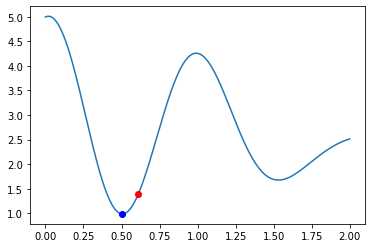

In [54]:
def evolutionary_optimization(population_size, generations):
    """
    Simple implementation of the evolutionary optimization algorith.

    Parameters:
        population_size (int): number of individuals in the population
        generations (int): number of generations to run the algorithm
    """

    # create the initial population
    population = np.random.uniform(start, end, population_size)

    # loop through the generations
    for generation in range(generations):
        # evaluate the population
        population_fitness = loss_function(population)

        # find the best individual
        best_fitness = min(population_fitness)

        best_individual = population[np.argmin(population_fitness)]

        # print the best individual
        print(
            f"Generation {generation}: best individual = {best_individual}, best fitness = {best_fitness}"
        )

        # create the next generation
        next_generation = np.array([])

        # keep the best individual
        next_generation = np.append(next_generation, best_individual)

        # create the rest of the next generation
        for _ in range(population_size - 1):
            # softmax population_fitness
            population_probs = population_fitness / sum(population_fitness)

            # pick two individuals based on their fitness
            individual_1 = np.random.choice(population, p=population_probs)
            individual_2 = np.random.choice(population, p=population_probs)

            # child is the average of parents
            child = (individual_1 + individual_2) / 2

            # mutation?
            if np.random.uniform(0, 1) < 0.1:
                child += np.random.uniform(-0.1, 0.1)

            # clamp the child to start, end
            child = min(max(start, child), end)

            # append the child
            next_generation = np.append(next_generation, child)

        # replace the population with the next generation
        population = next_generation

    return (best_individual, best_fitness)


# run the evolutionary optimization algorithm within our constraints
best_individual, best_fitness = evolutionary_optimization(3, 3)
print("")

# use more resources (100 evaluations)
best_individual2, best_fitness2 = evolutionary_optimization(10, 10)

# plot
plt.plot(x_loss, y_loss)
plt.plot(best_individual, best_fitness, 'ro')
plt.plot(best_individual2, best_fitness2, 'bo')


One of the problems is that genetic algorithms are hard to parallelize. We can parallelize evalutions within a generation, but not across generations as creation of new generations is sequential. Genetic algorithms are usually also quite slow, so this approach is not that popular for hyperparameter optimization, but the logic behind genetic algorithms is used in many scientific fields.

## Bayesian optimization

So, evolutionary approaches are in most cases too time consuming to be practically useful. On the other hand, the main problem with grid search and random search is that they do not use any information from the previous evaluations of $f(x)$, while this allows for easy parallelization it is suboptimal as by probing the loss function we gain information about it. The more information we have, the better we can model the loss function and by facilitating this information we can pick the next candidate hyperparameters in a better way. And this is the core idea behind Bayesian optimization. Bayesian optimization uses bayesian modelling to build a surrogate function that tries to mimic the loss function. The more actual measurements we have about how the loss function behaves with regards to hyperparameters, the better we can model it. And the better the model of the loss function, the better our next candidate hyperparameters can be. What is important is that the surrogate function can be easily probed, meaning that we can quickly test a number of candidate hyperparameters to find the best one that is then evaluted through the slow and tedious loss function $f(x)$. In the literature you will also sometime hear the term Sequential Model-Based Optimization (SMBO), this is essentialy the same thing as Bayesian optimization. It will become clear a bit later why this name is also appropriate.

The pseudocode for Bayesian optimization looks like this:

```
0. initiate the (prior) surrogate function for the loss function.
while n ≤ N do
    1. use the surrogate and acquisition functions to generate candidate hyperparameters in an informed way
    2. evaluate the candidate
    3. update the surrogate function using the latest evaluation
```

So, surrogate function is our replacement model of the real loss function. Another new term used above is the acquisition function. Acquisition function is the technique by which the surrogate function is used to select the next hyperparameter candidate from the search space.

### Surrogate functions (models)

The whole method is called Bayesian optimization because Bayesian methods are used for surrogate models as a rule. There are many reasons for this:

* We can easily incorporate prior knowledge about possible good values of ceratin hyperparaeters into our surrogate model.
* Bayesian methods give us an estimate of uncertainty, which is important for figuring out the next set of candidate hyperparameters.
* They are flexible enough to accommodate many different shapes of loss functions in many dimensions (Bayesian optimization usually works well up to 20 dimensions/hyperparameters).

The most commonly used model are the Gaussian processes (GP). GP are useful when we have some data points, and we want to make predictions about values at new, unobserved points. GP help us do this by treating our predictions as random variables. Instead of giving a single prediction, a GP provides a probability distribution over possible values for each point, as you will see this is very important when looking for a new set of candidate hyperparameters.

Another surrogate model that can be commonly found in packages for Bayesian optimization is the Tree Parzen Estimator (TPE). Here, we will not delve under the hood of these surrogate models. A detailed explanation can be found in these resources:

* Distill - A Visual Exploration of Gaussian Processes, https://distill.pub/2019/visual-exploration-gaussian-processes.
* J Bergstra, R Bardenet, Y Bengio, B Kégl - Algorithms for hyper-parameter optimization, http://papers.neurips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf.

### Acquisition functions

Once we have our surrogate function that approximates the real loss function to the best of our ability, we use an acquisition function to find good candidate hyperparameters for the next iteration. The goal is to find an approach that balances exploitation and exploration. Expoitation means that we will focus on more promising areas where the surrogate function is predicting better results, exploration means that we will focus on areas that we did not yet visit to get a better feeling about what is happening there. Below are descriptions of some commonly used acquisition functions.

* Lower confidence bound (LCB) simply takes the predicted values from the surrogate function and subtracts the (double) predicted standard deviation at each point. This way we get the lower bound of the 95% confidence interval. We then pick our next candidate hyperparameters at the location where the minimal value of this bound is. This approach mainly targets exploitability and is prone to getting stuck in local minima as it does not have an exploration mechanism.
* Probability of Improvement (PI) estimates the probability that a point will improve upon the current best observed value. It considers the difference between the mean prediction and the current best value, taking into account the uncertainty in the surrogate model. This approach also does not have an explicit exploration mechanism.
* Expected Improvement (EI) selects points that have the potential to improve upon the best observed value. It quantifies the expected improvement over the current best value by considers the best observed value, the mean prediction of the surrogate model and its uncertainty. This approach tries to facilitate both exploitation and exploration mechanisms.

In the literature you will find several more acquisition functions, below is the implementation of the three we mentioned can be found below.

In [136]:
from scipy.stats import norm

def lower_confidence_bound(y_pred, y_std):
    """
    Lower confidence bound acquisition function.

    Parameters:
        y_pred (float): values of the surrogate function
        y_std (float): the standard deviation of the surrogate function
    """
    return (max(y_pred) - y_pred) + 2 * y_std

def probability_of_improvement(best_y, y_pred, y_std):
    """
    Probability of improvement acquisition function.

    Parameters:
        best_y (float): the best observed value of the loss function so far
        y_pred (float): values of the surrogate function
        y_std (float): the standard deviation of the surrogate function
    """
    z = (best_y - y_pred) / y_std
    pi = norm.cdf(z)
    return pi

def expected_improvement(best_y, y_pred, y_std):
    """
    Expected improvement acquisition function.

    Parameters:
        best_y (float): the best observed value of the loss function so far
        y_pred (float): values of the surrogate function
        y_std (float): the standard deviation of the surrogate function
    """
    delta = best_y - y_pred
    z = delta / y_std
    ei = delta * norm.cdf(z) + y_std * norm.pdf(z)
    return ei


### Putting it all together

At this point we have all the information to use Bayesian optimization in practice. The code snippet below uses GP with a radial basis function kernel (RBF) for building the surrogate function. You could use anything suitable for the surrogate function, as long as it can fit the data well and it outputs both the mean prediction and the uncertainty in it. For finding new candidate hyperparameters based on the surrogate function you can use one of the above approaches. 

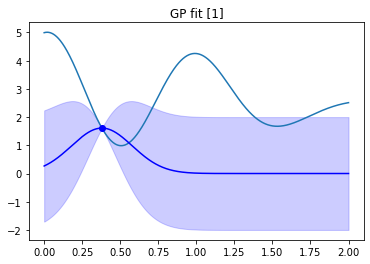

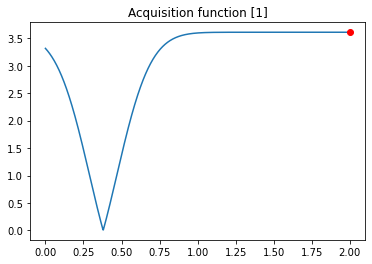

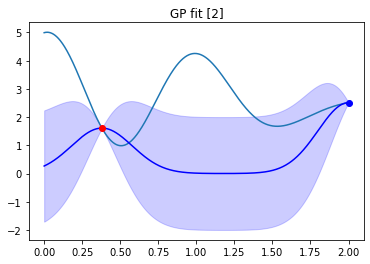

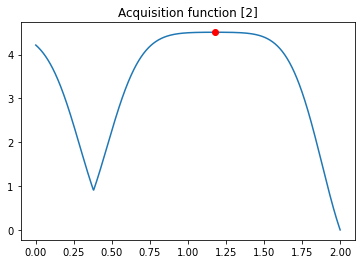

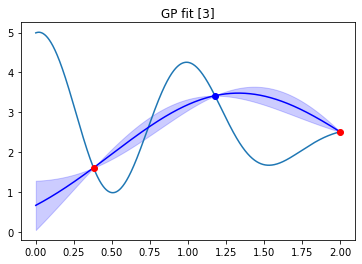

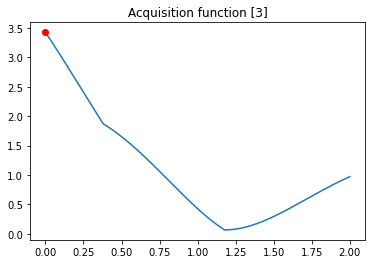

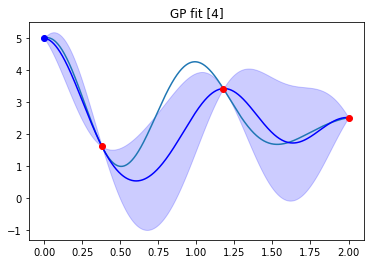

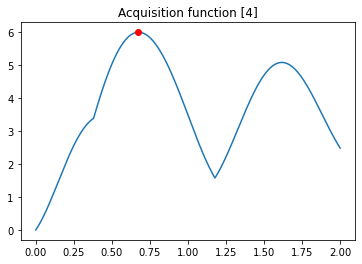

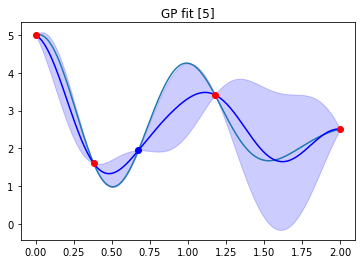

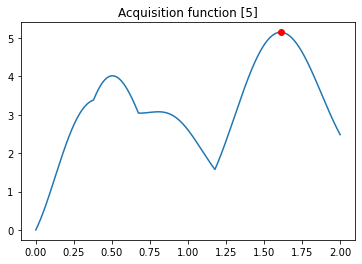

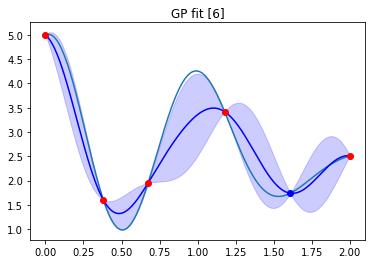

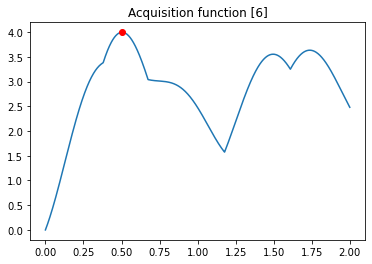

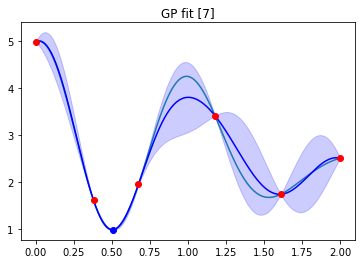

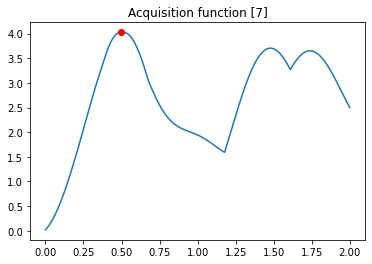

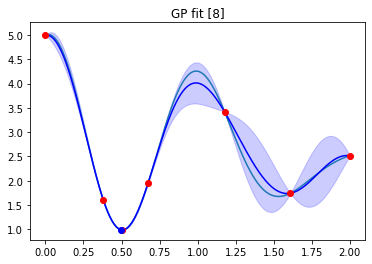

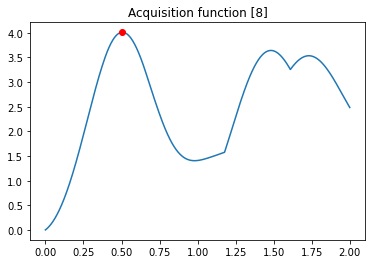

/Users/jure/miniconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


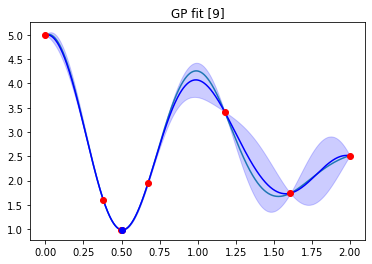

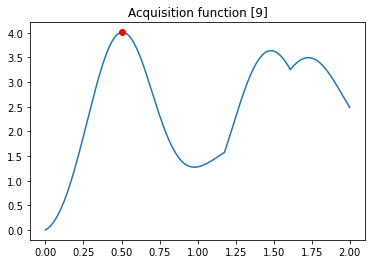

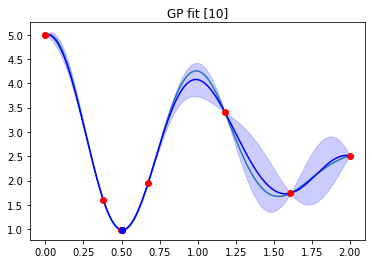

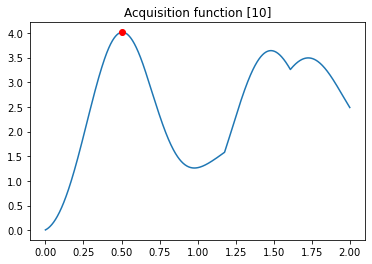


min x_bo = 0.5065065065065065


In [139]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# GP with an RBF kernel
kernel = RBF(length_scale=0.2)
gp_model = GaussianProcessRegressor(kernel=kernel)

# storage for our hyperparameters and their loss
x_bo = []
y_bo = []

# get the first candidate
x = np.random.uniform(start, end)

# fit the Gaussian process model to the sampled points
for i in range(10):
    # evaluate the candidate
    y = loss_function(x)

    # append to the list
    x_bo.append(x)
    y_bo.append(y)

    # fit the model
    gp_model.fit(np.array(x_bo).reshape(-1, 1), y_bo)

    # predictions and std in our x_loss domain
    y_pred, y_std = gp_model.predict(x_loss.reshape(-1, 1), return_std=True)

    # plot
    plt.figure()
    plt.title(f"GP fit [{i+1}]")
    plt.plot(x_loss, y_loss)
    plt.plot(x_loss, y_pred, color="blue")
    plt.plot(x_bo[:-1], y_bo[:-1], "ro")
    plt.plot(x_bo[-1], y_bo[-1], "bo")
    plt.fill_between(
        x_loss, y_pred - 2 * y_std, y_pred + 2 * y_std, color="blue", alpha=0.2
    )
    plt.show()

    # get the next candidate with the acquisition function
    af_y = lower_confidence_bound(y_pred, y_std)
    #af_y = probability_of_improvement(min(y_bo), y_pred, y_std)
    #af_y = expected_improvement(min(y_bo), y_pred, y_std)

    # find all points with max value
    max_af_y = 0
    af_y_indexes = []
    for j in range(len(af_y)):
        if af_y[j] > max_af_y:
            af_y_indexes = [j]
            max_af_y = af_y[j]
        elif af_y[j] == max_af_y:
            af_y_indexes.append(j)

    # pick one at random
    x_index = np.random.choice(af_y_indexes)
    x = x_loss[x_index]

    plt.figure()
    plt.title(f"Acquisition function [{i+1}]")
    plt.plot(x_loss, af_y)
    plt.plot(x, af_y[x_index], "ro")
    plt.show()

# report best
min_x_bo = x_bo[np.argmin(y_bo)]
print(f"\nmin x_bo = {min_x_bo}")


## Hybrid approaches

It is not uncommon that we combine multiple of the approaches above. In our toy example, we might first use grid or random search to get the value of the loss function at a couple of different location (for example 5) and then use those 5 locations as the starting point for the Bayesian optimization. This will give the Bayesian optimizer a much better starting point and a much better estimate of the surrogate function at the beginning. As a results, subsequent operations will be more efficient. 

## References

* Distill - A Visual Exploration of Gaussian Processes, https://distill.pub/2019/visual-exploration-gaussian-processes.
* J Bergstra, R Bardenet, Y Bengio, B Kégl - Algorithms for hyper-parameter optimization, http://papers.neurips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf.
* Adams R - A Tutorial on Bayesian Optimization for Machine Learning, https://www.cs.toronto.edu/~rgrosse/courses/csc411_f18/tutorials/tut8_adams_slides.pdf.
* Borealis AI - Bayesian optimization, https://www.borealisai.com/research-blogs/tutorial-8-bayesian-optimization/.
* Yenigün O - Step-by-Step Guide to Bayesian Optimization: A Python-based Approach, https://medium.com/@okanyenigun/step-by-step-guide-to-bayesian-optimization-a-python-based-approach-3558985c6818.